# XGBoost

##### Runtime Environment Configuration

Ensure XGBoost is installed

Use SHAP (SHapley Additive exPlanations) to help interpret output from XGBoost

In [1]:
import numpy as np
import pandas as pd
import afqinsight as afqi
import matplotlib.pyplot as plt

## Dataset

##### Dataset Information

Human Connectome Project Young Adult (HCP-YA)
- https://www.humanconnectome.org/study/hcp-young-adult

Using Human Connectome Project Young Adult (HCP-YA) 1200 Subject Release:
- https://www.humanconnectome.org/study/hcp-young-adult/document/1200-subjects-data-release

    Release Reference Manual:
    - https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf

In [2]:
def _get_subjects():
    """
    Helper function to identify HCP-YA subjects that have been processed by pyAFQ
    """
    import s3fs
    
    fs = s3fs.S3FileSystem()
    
    return [f.split('sub-')[1] for f in fs.glob('hcp.afq/derivatives/afq/sub-*')]

#### `nodes.csv`

Download and combine all HCP-YA 1200 Subject pyAFQ bundle profiles from `hcp.afq` S3 repository

In [3]:
def _generate_nodes_csv(callsum_only=False):
    """
    genearate `nodes.csv` from HCP-YA pyAFQ bundle profiles.
    """
    import s3fs
    import os
    from os.path import exists
    import pandas as pd
    
    if exists('nodes.csv'):
        print('nodes.csv already exists! to regenerate delete file and rerun.')
        return

    fs = s3fs.S3FileSystem()

    dfs = []
    
    subjects = _get_subjects()
        
    os.makedirs('hcp.afq/test', exist_ok=True)
    
    for subject in subjects:
        # NOTE assuming one session
        fname = f'sub-{subject}_dwi_space-RASMM_model-CSD_desc-prob-afq_profiles.csv'
        local_fname = f'hcp.afq/test/{fname}'
        
        if not exists(local_fname):
            if fs.ls(f'hcp.afq/derivatives/afq/sub-{subject}/ses-01/{fname}'):
                fs.get(
                    f'hcp.afq/derivatives/afq/sub-{subject}/ses-01/{fname}',
                    local_fname
                )
        
        if exists(local_fname):
            profiles = pd.read_csv(local_fname, index_col=[0])
            profiles.insert(0, 'subjectID', subject)
        
            dfs.append(profiles)
        
    combined_df = pd.concat(dfs)
    
    # filter the available tracts to only those in callosum
    if callsum_only:
        combined_df = combined_df[combined_df.tractID.isin(['AntFrontal', 'Motor', 'Occipital', 'Orbital',
           'PostParietal', 'SupFrontal', 'SupParietal', 'Temporal'])]

    combined_df.reset_index(inplace=True, drop=True)
    combined_df.to_csv('nodes.csv', index=False)

In [4]:
_generate_nodes_csv()

nodes.csv already exists! to regenerate delete file and rerun.


#### `subjects.csv`

##### HCP-YA 1200 Subject Behavioral Data

**NOTE you must have access to HCP dataset**

To get access "Create an Account":
- https://db.humanconnectome.org/

**NOTE you must manually download the behavoiral data locally**

Data Dictonary:
- https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release

**WARNING: Potential file name collision.** 
  
  - This `subjects.csv` is different from the `HCP-YA-SGL.ipynb` `subjects.csv` as it contains more than just the reading behavioral trait.

In [5]:
def _generate_subjects_csv():
    """
    generate `subjects.csv` from entire HCP-YA behavioral data
    """
    import os
    from os.path import exists
    import errno
    
    if exists('subjects.csv'):
        print('subjects.csv already exists! to regenerate delete file and rerun.')
        return
    
    if not exists('unrestricted_1200_behavioral.csv'):
        raise FileNotFoundError(
            errno.ENOENT, os.strerror(errno.ENOENT),
            'unrestricted_1200_behavioral.csv'
        )
    
    subjects = _get_subjects()
    
    df = pd.read_csv('unrestricted_1200_behavioral.csv')
    df = df[df['Subject'].isin(list(map(int, subjects)))]
    df = df.rename(columns={'Subject': 'subjectID'})
    df.to_csv('subjects.csv', index=False)

In [6]:
_generate_subjects_csv()

subjects.csv already exists! to regenerate delete file and rerun.


## Model

In [7]:
def _xgb(behavioral_column='ReadEng_Unadj', hyperparam_search=False):
    from xgboost import XGBRegressor
    from skopt import BayesSearchCV
    from sklearn.model_selection import train_test_split
    from datetime import datetime

    start = datetime.now()
    print(behavioral_column)
    
    X, y, groups, feature_names, group_names, subjects, *_ = afqi.load_afq_data(
        '.',
        target_cols=[behavioral_column],
        dwi_metrics=['dki_fa', 'dki_md', 'dki_mk', 'dki_awf']
    )
        
    if np.isnan(y).any():
        print('excluding subjects with missing behavoiral information:', np.array(subjects)[np.where(np.isnan(y))])
        y = y[np.where(np.isnan(y) == False)]
        X = X[np.where(np.isnan(y) == False)]
        subjects = list(np.array(subjects)[np.where(np.isnan(y) == False)])
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.33,
        random_state=1729,
    )

    if hyperparam_search:
        xgb_reg = XGBRegressor(
            objective="reg:squarederror",
            nthread=4
        )
        
        params = {
            "n_estimators": (50, 2001),
            "min_child_weight": (1, 11),
            "gamma": (0.01, 5.0, "log-uniform"),
            "eta": (0.005, 0.5, "log-uniform"),
            "subsample": (0.2, 1.0),
            "colsample_bytree": (0.2, 1.0),
            "max_depth": (2, 6),
        }

        opt = BayesSearchCV(
            xgb_reg,
            params,
            n_iter=100,
        )

        _ = opt.fit(X_train, y_train)

        train_score = opt.score(X_train, y_train)
        test_score = opt.score(X_test, y_test)
        
        # set the best estimator as xgb_reg to get feature imporance
        xgb_reg = opt.best_estimator_
    else:
        xgb_reg = XGBRegressor(
            objective="reg:squarederror",
            nthread=4,
            colsample_bytree=0.86,
            gamma=0.01,
            learning_rate=0.005,
            max_depth=2,
            min_child_weight=2,
            n_estimators=3000,
            subsample=0.2
        )
        
        xgb_reg.fit(X_train, y_train)
                
        train_score = xgb_reg.score(X_train, y_train)
        test_score = xgb_reg.score(X_test, y_test)

    print('Elapsed time: ', datetime.now() - start)
    
    # get information on the XGBRegressor
    print(xgb_reg)
#     print(xgb_reg.importance_type)
        
    # feature importance
    import xgboost
    
    # could plot all features by looking for non-zero feature_importances_
    num_features = 30

    #     plt.rcParams['figure.figsize'] = [5, 15]

    #########
    # using get_booster
    
    #     print(xgb_reg.get_booster())

    # NaN
#     display(
#         pd.Series(
#             data=xgb_reg.get_booster().get_fscore(),
#             index=feature_names
#         ).sort_values(ascending=False)
#     )
    
    # NaN
#     display(
#         pd.Series(
#             data=xgb_reg.get_booster().get_score(),
#             index=feature_names
#         ).sort_values(ascending=False)
#     )

    # NaN
#     display(
#         pd.Series(
#             data=xgb_reg.get_booster().get_score(importance_type='weight'),
#             index=feature_names
#         ).sort_values(ascending=False)
#     )

    # NaN
#     display(
#         pd.Series(
#             data=xgb_reg.get_booster().get_score(importance_type='gain'),
#             index=feature_names
#         ).sort_values(ascending=False)
#     )
    
    #########
    # using feature_importances_ same information as plot_importance 'gain'
    
    #     display(
#         pd.Series(
#             data=xgb_reg.feature_importances_,
#             index=feature_names
#         ).sort_values(ascending=False)
#     )

    # get the top num_features by gain
#     sorted_idx = xgb_reg.feature_importances_.argsort()[::-1][:num_features]
#     display(pd.Series(data=xgb_reg.feature_importances_[sorted_idx]))
        
#     plt.barh(np.array(list(map(''.join, map(str, feature_names))))[sorted_idx], 
#              xgb_reg.feature_importances_[sorted_idx])
#     plt.show()
    
    #########
    # using plot interface, inconsistent results using XGBoost 
    # feature importance measures, switch to using SHAP
    
    # default is weight
#     xgboost.plot_importance(xgb_reg, max_num_features=15)
#     plt.show()
    

    # set feature names, so identifable in importance plot
#     xgb_reg.get_booster().feature_names = list(map(''.join, map(str, feature_names)))
    
#     print('Weight: The number of times a feature is used to split the data across all trees.')
#     xgboost.plot_importance(xgb_reg, max_num_features=num_features, title='Feature importance (weight)', importance_type='weight')
#     plt.show()
    
#     # xgb_reg.feature_importances_ is gain
#     print('Gain. The average training loss reduction gained when using a feature for splitting.')
#     xgboost.plot_importance(xgb_reg, max_num_features=num_features, title='Feature importance (gain)', importance_type='gain')
#     plt.show()
    
#     print('Cover. The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.')
#     xgboost.plot_importance(xgb_reg, max_num_features=num_features, title='Feature importance (cover)',importance_type='cover')
#     plt.show()
    
    import shap
    
    explainer = shap.Explainer(xgb_reg, feature_names=list(map(''.join, map(str, feature_names))))

    # full data
#     shap_values = explainer(X)
#     shap.plots.bar(shap_values, max_display=num_features)
#     plt.show()
    
    # train
#     shap_values = explainer(X_train)
#     shap.plots.bar(shap_values, max_display=num_features)
#     plt.show()

    # test
    shap_values = explainer(X_test)
    shap.plots.bar(shap_values, max_display=num_features)
    plt.show()
    
    # To get an overview of which features are most important for a model
    # plot the SHAP values of every feature for every sample. The plot
    # sorts features by the sum of SHAP value magnitudes over all samples,
    # and uses SHAP values to show the distribution of the impacts each
    # feature has on the model output. The color represents the feature
    # value (red high, blue low).
    shap.plots.beeswarm(shap_values, max_display=num_features)
    plt.show()

    return pd.Series(data=[behavioral_column, train_score, test_score], 
                     index=['behavior score', 'train score', 'test score'])

### Reading Scores

- Compare to Callosum Factors model in `callosum.ipynb` and SGL model `HCP-YA-SGL.ipynb`

- Compare execution times and scores for fixed and optimized hyperparameters models

ReadEng_Unadj
Elapsed time:  0:02:38.857460
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.86, gamma=0.01, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.005, max_delta_step=0, max_depth=2,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=4, nthread=4, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.2, tree_method='exact', validate_parameters=1,
             verbosity=None)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


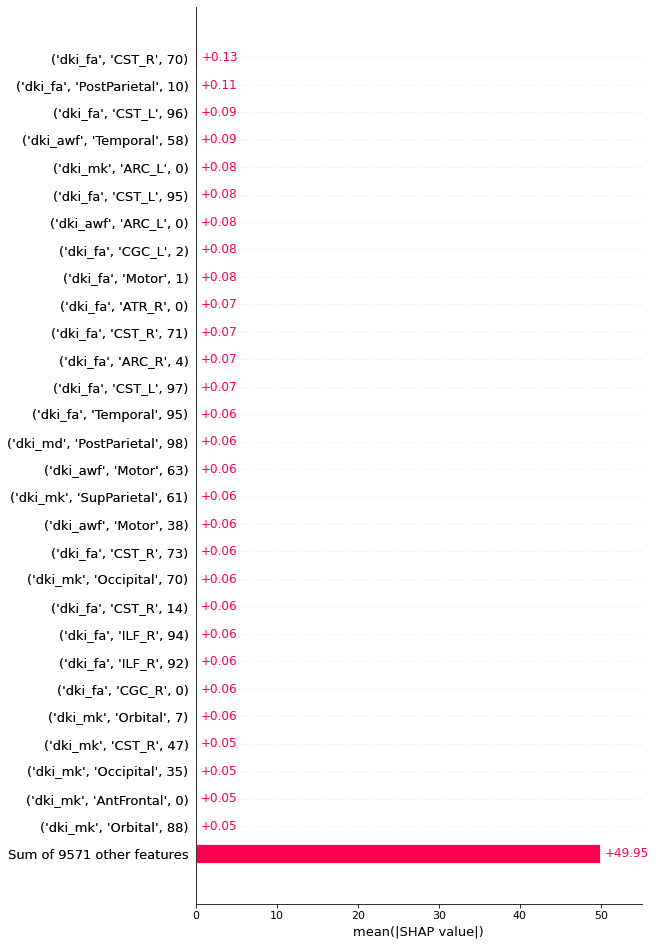

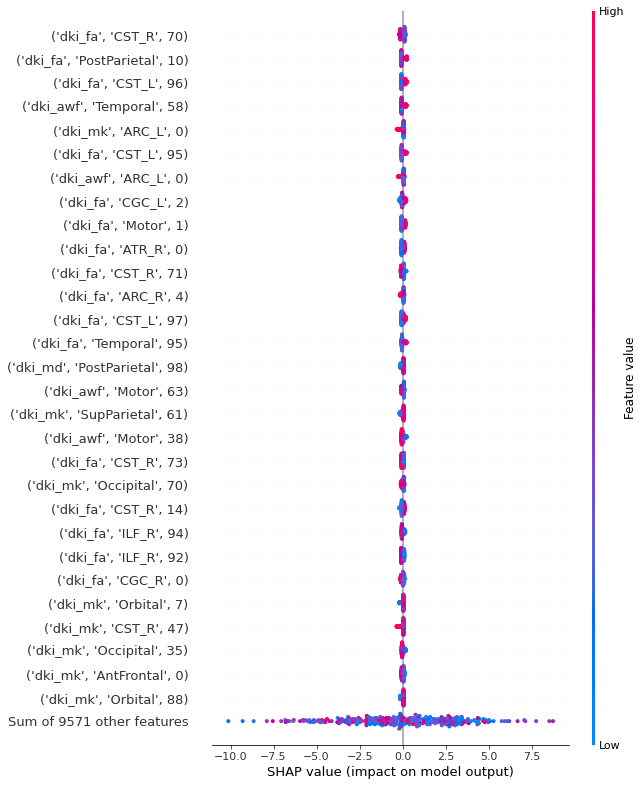

behavior score    ReadEng_Unadj
train score            0.793857
test score             0.088254
dtype: object

In [8]:
_xgb()

In [ ]:
_xgb(hyperparam_search=True)

ReadEng_Unadj


**Doesn't Appear to be much benefit to running the hyperparameter search**

## All Behavioral Traits

In [185]:
alertness_scores = []

alertness_columns = [
    # Cognitive Status (Mini Mental Status Exam)
    'MMSE_Score',
    # Sleep (Pittsburgh Sleep Questionnaire)
    'PSQI_Score'
]

for alertness_column in alertness_columns:
    alertness_scores.append(_xgb(alertness_column))
    
alertness_df = pd.DataFrame(data=alertness_scores)
alertness_df.set_index('behavior score', inplace=True)

MMSE_Score
Elapsed time:  0:02:40.905063
PSQI_Score
Elapsed time:  0:02:44.526171


In [134]:
cognitive_scores = []

cognitive_columns = [
    # Episodic Memory (Picture Sequence Memory)
    'PicSeq_Unadj',
    # Executive Function/Cognitive Flexibility (Dimensional Change Card Sort)
    'CardSort_Unadj',
    # Executive Function/Inhibition (Flanker Task)
    'Flanker_Unadj',
    # Fluid Intelligence (Penn Progressive Matrices)
    'PMAT24_A_CR',
    'PMAT24_A_SI',
    'PMAT24_A_RTCR',
    # Language/Reading Decoding (Oral Reading Recognition)
    'ReadEng_Unadj',
    # Language/Vocabulary Comprehension (Picture Vocabulary)
    'PicVocab_Unadj',
    # Processing Speed (Pattern Completion Processing Speed)
    'ProcSpeed_Unadj',
    # Self-regulation/Impulsivity (Delay Discounting)
    'DDisc_SV_1mo_200',
    'DDisc_SV_6mo_200',
    'DDisc_SV_1yr_200',
    'DDisc_SV_3yr_200',
    'DDisc_SV_5yr_200',
    'DDisc_SV_10yr_200',
    'DDisc_SV_1mo_40K',
    'DDisc_SV_6mo_40K',
    'DDisc_SV_1yr_40K',
    'DDisc_SV_3yr_40K',
    'DDisc_SV_5yr_40K',
    'DDisc_SV_10yr_40K',
    'DDisc_AUC_200',
    'DDisc_AUC_40K',
    # Spatial Orientation (Variable Short Penn Line Orientation Test)
    'VSPLOT_TC',
    'VSPLOT_CRTE',
    'VSPLOT_OFF',
    # Sustained Attention (Short Penn Continuous Performance Test)
    'SCPT_TP',
    'SCPT_TN',
    'SCPT_FP',
    'SCPT_FN',
    'SCPT_TPRT',
    'SCPT_SEN',
    'SCPT_SPEC',
    'SCPT_LRNR',
    # Verbal Episodic Memory (Penn Word Memory Test)
    'IWRD_TOT',
    'IWRD_RTC',
    # Working Memory (List Sorting)
    'ListSort_Unadj'
]

for cognitive_column in cognitive_columns:
    cognitive_scores.append(_xgb(cognitive_column))
    
cognitive_df = pd.DataFrame(data=cognitive_scores)
cognitive_df.set_index('behavior score', inplace=True)

PicSeq_Unadj
excluding subjects with missing behavoiral information: [284646]
Elapsed time:  0:02:33.809897
CardSort_Unadj
excluding subjects with missing behavoiral information: [140319 393247]
Elapsed time:  0:02:43.668430
Flanker_Unadj
Elapsed time:  0:02:42.601461
PMAT24_A_CR
excluding subjects with missing behavoiral information: [109830 137431 236130 614439]
Elapsed time:  0:02:46.256436
PMAT24_A_SI
excluding subjects with missing behavoiral information: [109830 137431 236130 614439]
Elapsed time:  0:02:47.606344
PMAT24_A_RTCR
excluding subjects with missing behavoiral information: [109830 137431 236130 614439]
Elapsed time:  0:02:52.162787
ReadEng_Unadj
Elapsed time:  0:02:40.759483
PicVocab_Unadj
Elapsed time:  0:02:42.165583
ProcSpeed_Unadj
Elapsed time:  1:23:28.779967
DDisc_SV_1mo_200
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:17.311988
DDisc_SV_6mo_200
excluding subjects with missing behavoiral information: [109830 236

In [135]:
emotion_scores = []

emotion_columns = [
    # Emotion Recognition (Penn Emotion Recognition Test)
    'ER40_CR',
    'ER40_CRT',
    'ER40ANG',
    'ER40FEAR',
    'ER40HAP',
    'ER40NOE',
    'ER40SAD',
    # Negative Affect 
    'AngAffect_Unadj',
    'AngHostil_Unadj',
    'AngAggr_Unadj',
    'FearAffect_Unadj',
    'FearSomat_Unadj',
    'Sadness_Unadj',
    # Psychological Well-being 
    'LifeSatisf_Unadj',
    'MeanPurp_Unadj',
    'PosAffect_Unadj',
    # Social Relationships 
    'Friendship_Unadj',
    'Loneliness_Unadj',
    'PercHostil_Unadj',
    'PercReject_Unadj',
    'EmotSupp_Unadj',
    'InstruSupp_Unadj',
    # Stress and Self Efficacy
    'PercStress_Unadj',
    'SelfEff_Unadj'
]

for emotion_column in emotion_columns:
    emotion_scores.append(_xgb(emotion_column))
    
emotion_df = pd.DataFrame(data=emotion_scores)
emotion_df.set_index('behavior score', inplace=True)

ER40_CR
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:14.188073
ER40_CRT
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:14.442164
ER40ANG
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:15.764951
ER40FEAR
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:15.040653
ER40HAP
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:11.528831
ER40NOE
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:15.431974
ER40SAD
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:15.979772
AngAffect_Unadj
excluding subjects with missing behavoiral information: [480141]
Elapsed time:  0:02:15.546167
AngHostil_Unadj
excluding subjects with missing behavoiral informati

In [136]:
motor_scores = [] 

motor_columns = [
    # Endurance (2 minute walk test)
    'Endurance_Unadj',
    # Locomotion (4-meter walk test)
    'GaitSpeed_Comp',
    # Dexterity (9-hole Pegboard)
    'Dexterity_Unadj',
    # Strength (Grip Strength Dynamometry)
    'Strength_Unadj'
]

for motor_column in motor_columns:
    motor_scores.append(_xgb(motor_column))
    
motor_df = pd.DataFrame(data=motor_scores)
motor_df.set_index('behavior score', inplace=True)

Endurance_Unadj
excluding subjects with missing behavoiral information: [147030 578057]
Elapsed time:  0:02:17.313715
GaitSpeed_Comp
Elapsed time:  0:02:17.719039
Dexterity_Unadj
Elapsed time:  0:02:14.104854
Strength_Unadj
excluding subjects with missing behavoiral information: [206222]
Elapsed time:  0:02:14.656687


In [137]:
personality_scores = []

personality_columns = [
    # Five Factor Model (NEO-FFI)
    'NEOFAC_A',
    'NEOFAC_O',
    'NEOFAC_C',
    'NEOFAC_N',
    'NEOFAC_E'
]

for personality_column in personality_columns:
    personality_scores.append(_xgb(personality_column))
    
personality_df = pd.DataFrame(data=personality_scores)
personality_df.set_index('behavior score', inplace=True)

NEOFAC_A
excluding subjects with missing behavoiral information: [109830 614439]
Elapsed time:  0:02:16.076742
NEOFAC_O
excluding subjects with missing behavoiral information: [109830 614439]
Elapsed time:  0:02:15.909564
NEOFAC_C
excluding subjects with missing behavoiral information: [109830 614439]
Elapsed time:  0:02:17.533844
NEOFAC_N
excluding subjects with missing behavoiral information: [109830 614439]
Elapsed time:  0:02:15.275977
NEOFAC_E
excluding subjects with missing behavoiral information: [109830 614439]
Elapsed time:  0:02:15.493154


In [138]:
sensory_scores = []

sensory_columns = [
    # Audition (Words in Noise)
    'Noise_Comp',
    # Olfaction (Odor Identification Test)
    'Odor_Unadj',
    # Pain (Pain Intensity and Interference Surveys)
    'PainInterf_Tscore',
    # Taste (Taste Intensity Test)
    'Taste_Unadj',
    # Contrast Sensitivity (Mars Contrast Sensitivity)
    'Mars_Log_Score',
    'Mars_Errs',
    'Mars_Final'
]

for sensory_column in sensory_columns:
    sensory_scores.append(_xgb(sensory_column))
    
sensory_df = pd.DataFrame(data=sensory_scores)
sensory_df.set_index('behavior score', inplace=True)

Noise_Comp
excluding subjects with missing behavoiral information: [146129 160830 182032 193441 280739 480141 723141 753150]
Elapsed time:  0:02:14.673014
Odor_Unadj
excluding subjects with missing behavoiral information: [160830 480141]
Elapsed time:  0:02:12.910434
PainInterf_Tscore
excluding subjects with missing behavoiral information: [480141]
Elapsed time:  0:02:14.581486
Taste_Unadj
excluding subjects with missing behavoiral information: [119126 160830 200917 480141 760551]
Elapsed time:  0:02:14.502117
Mars_Log_Score
excluding subjects with missing behavoiral information: [109830 236130 614439]
Elapsed time:  0:02:10.591314
Mars_Errs
excluding subjects with missing behavoiral information: [109830 123521 144731 236130 569965 614439]
Elapsed time:  0:02:13.885176
Mars_Final
excluding subjects with missing behavoiral information: [109830 123521 144731 236130 569965 614439]
Elapsed time:  0:02:10.843059


## Results

In [177]:
dfs = {
    "alertness": alertness_df,
    "cognitive": cognitive_df, 
    "emotion": emotion_df,
    "motor": motor_df,
    "personality": personality_df,
    "sensory": sensory_df
}

scores = pd.concat(dfs)

with pd.option_context('display.max_rows', len(scores)):
    display(scores)

train score  test score
            behavior score                            
alertness   MMSE_Score            0.777256   -0.111672
            PSQI_Score            0.771951   -0.010720
cognitive   PicSeq_Unadj          0.774335   -0.011519
            CardSort_Unadj        0.747309   -0.039733
            Flanker_Unadj         0.776229    0.038538
            PMAT24_A_CR           0.771092   -0.137994
            PMAT24_A_SI           0.778414   -0.158704
            PMAT24_A_RTCR         0.766654   -0.078807
            ReadEng_Unadj         0.793857    0.088254
            PicVocab_Unadj        0.789212    0.146630
            ProcSpeed_Unadj       0.778039   -0.019371
            DDisc_SV_1mo_200      0.774994   -0.102205
            DDisc_SV_6mo_200      0.781698   -0.115953
            DDisc_SV_1yr_200      0.782531   -0.091038
            DDisc_SV_3yr_200      0.775210   -0.153845
            DDisc_SV_5yr_200      0.770502   -0.163351
            DDisc_SV_10yr_200     0.773540   -0.226806
            DDisc_SV_1mo_40K      0.768706   -0.208054
            DDisc_SV_6mo_40K      0.769562   -0.120877
            DDisc_SV_1yr_40K      0.780761   -0.141143
            DDisc_SV_3yr_40K      0.785528   -0.079367
            DDisc_SV_5yr_40K      0.782444   -0.060814
            DDisc_SV_10yr_40K     0.777228   -0.116633
            DDisc_AUC_200         0.770590   -0.152334
            DDisc_AUC_40K         0.780485   -0.062167
            VSPLOT_TC             0.771644   -0.061112
            VSPLOT_CRTE           0.769377    0.001530
            VSPLOT_OFF            0.773661   -0.343184
            SCPT_TP               0.790540   -0.128633
            SCPT_TN               0.760243   -0.120112
            SCPT_FP               0.779630   -0.110089
            SCPT_FN               0.788241   -0.130426
            SCPT_TPRT             0.759621   -0.071043
            SCPT_SEN              0.783366   -0.125931
            SCPT_SPEC             0.591244   -0.112051
            SCPT_LRNR             0.843407   -0.087873
            IWRD_TOT              0.744323   -0.066553
            IWRD_RTC              0.755236   -0.135578
            ListSort_Unadj        0.773677    0.019871
emotion     ER40_CR               0.757460   -0.099629
            ER40_CRT              0.744417   -0.048264
            ER40ANG               0.782531   -0.106833
            ER40FEAR              0.774151   -0.101925
            ER40HAP               0.798960   -0.655182
            ER40NOE               0.757640   -0.097980
            ER40SAD               0.770480   -0.124277
            AngAffect_Unadj       0.761325   -0.043905
            AngHostil_Unadj       0.759932   -0.040460
            AngAggr_Unadj         0.777921   -0.039038
            FearAffect_Unadj      0.769048   -0.056117
            FearSomat_Unadj       0.756833   -0.068857
            Sadness_Unadj         0.778479   -0.034909
            LifeSatisf_Unadj      0.776463   -0.043156
            MeanPurp_Unadj        0.778068   -0.077840
            PosAffect_Unadj       0.765272   -0.046800
            Friendship_Unadj      0.776463   -0.049509
            Loneliness_Unadj      0.773915   -0.041071
            PercHostil_Unadj      0.771608   -0.052082
            PercReject_Unadj      0.767528   -0.044490
            EmotSupp_Unadj        0.771687   -0.080632
            InstruSupp_Unadj      0.775360    0.003692
            PercStress_Unadj      0.781378   -0.039058
            SelfEff_Unadj         0.762310   -0.085195
motor       Endurance_Unadj       0.756683   -0.064569
            GaitSpeed_Comp        0.775398   -0.025701
            Dexterity_Unadj       0.774495    0.044735
            Strength_Unadj        0.783580    0.023800
personality NEOFAC_A              0.776217   -0.041037
            NEOFAC_O              0.777495   -0.079121
            NEOFAC_C              0.760829   -0.078598
            NEOFAC_N              0.775265   -0.095904
            NEOF

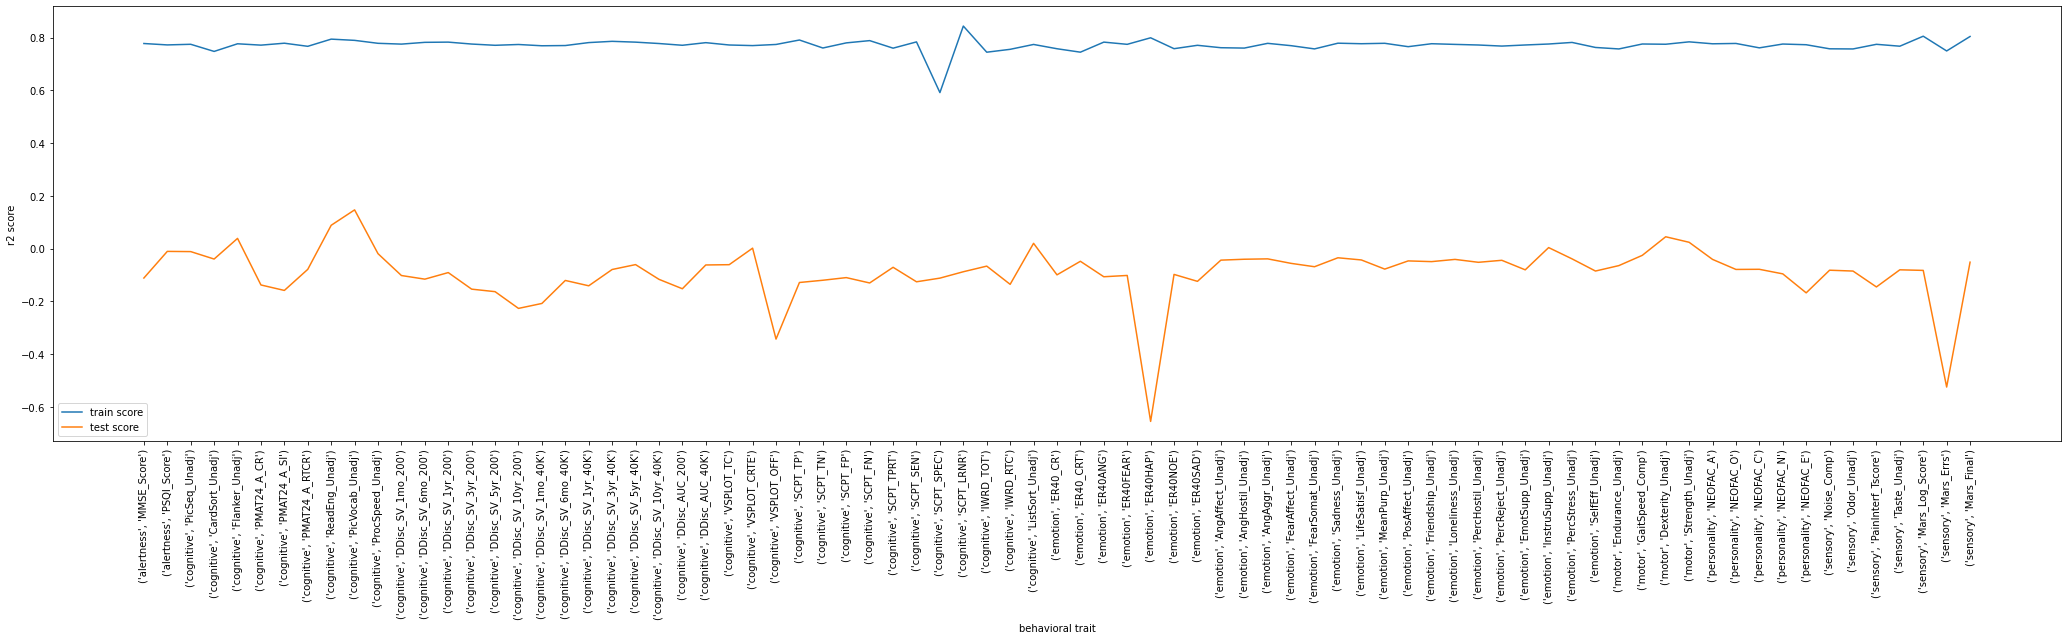

In [186]:
scores.plot(figsize=(36,8))
plt.xticks(range(0,len(scores.index)), scores.index, rotation = 90)
plt.xlabel('behavioral trait')
plt.ylabel('r2 score')
plt.show()

**Conclusion: overfitting, but test r2 is comparative to SGL**